## Import libraries

In [1]:
from CCD_implementation import logisitic_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, f1_score
import numpy as np
import pandas as pd
import openml
from generating_dataset import generate_dataset
from preprocessing import split, check_feature_sample_ratio, delete_corr_columns, fill_na, assign_target_column, add_permuted_columns,  drop_categorical

## Synthetic dataset experimnets

In [2]:
n_values = [100, 200, 300, 400, 500] 
p_values = [0.4, 0.5, 0.6, 0.7]
d_values = [10, 20, 50, 100]
g_values = [0.1, 0.25, 0.5, 0.75, 1.0]
# n_values = [100, 500, 1000] 
# p_values = [0.5]  # Fix p = 0.5
# d_values = [10, 50, 100]
# g_values = [0.1, 0.5, 1.0]

results = []

for n in n_values:
    for p in p_values:
        for d in d_values:
            for g in g_values:
                X, y = generate_dataset(p, n, d, g)
                X_train, X_test = X[:int(0.8*n)],  X[int(0.8*n):]
                y_train, y_test = y[:int(0.8*n)],  y[int(0.8*n):]

                log_reg_ccd = logisitic_regression()
                log_reg_sklearn = LogisticRegression(penalty=None)
                log_reg_ccd.fit(X_train, y_train, max_iter=100, weights=True, fit_intercept=True)

                log_reg_sklearn.fit(X_train, y_train)

                y_proba_ccd = log_reg_ccd.predict_proba(X_test)
                y_proba_sklearn = log_reg_sklearn.predict_proba(X_test)[:, 1]

                y_pred_ccd = log_reg_ccd.predict(X_test)
                y_pred_sklearn = log_reg_sklearn.predict(X_test)

                roc_auc_ccd = roc_auc_score(y_test, y_proba_ccd)
                balanced_accuracy_ccd = balanced_accuracy_score(y_test, y_pred_ccd)

                roc_auc_sklearn = roc_auc_score(y_test, y_proba_sklearn)
                balanced_accuracy_sklearn = balanced_accuracy_score(y_test, y_pred_sklearn)

                results.append({
                    'n': n,
                    'p': p,
                    'd': d,
                    'g': g,
                    'roc_auc_ccd': roc_auc_ccd,
                    'roc_auc_sklearn': roc_auc_sklearn,
                    'balanced_accuracy_ccd': balanced_accuracy_ccd,
                    'balanced_accuracy_sklearn': balanced_accuracy_sklearn
                })
            
results_df = pd.DataFrame(results)

In [10]:
def plot_comparison(parameter, metric, df):
    plt.figure(figsize=(12, 6))
    
    plt.plot(df[parameter], df[f'{metric}_ccd'], label='LogRegCCD', color='blue', marker='o')
    plt.plot(df[parameter], df[f'{metric}_sklearn'], label='LogisticRegression (sklearn)', color='red', marker='x')
    
    plt.title(f'{metric} Comparison - {parameter}')
    plt.xlabel(parameter)
    plt.ylabel(f'{metric}')
    plt.legend()
    plt.show()

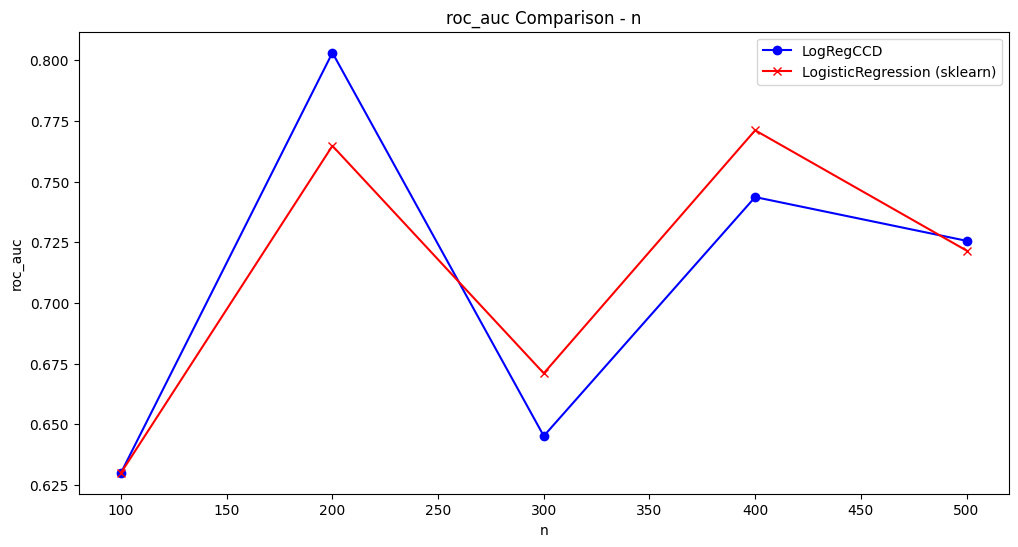

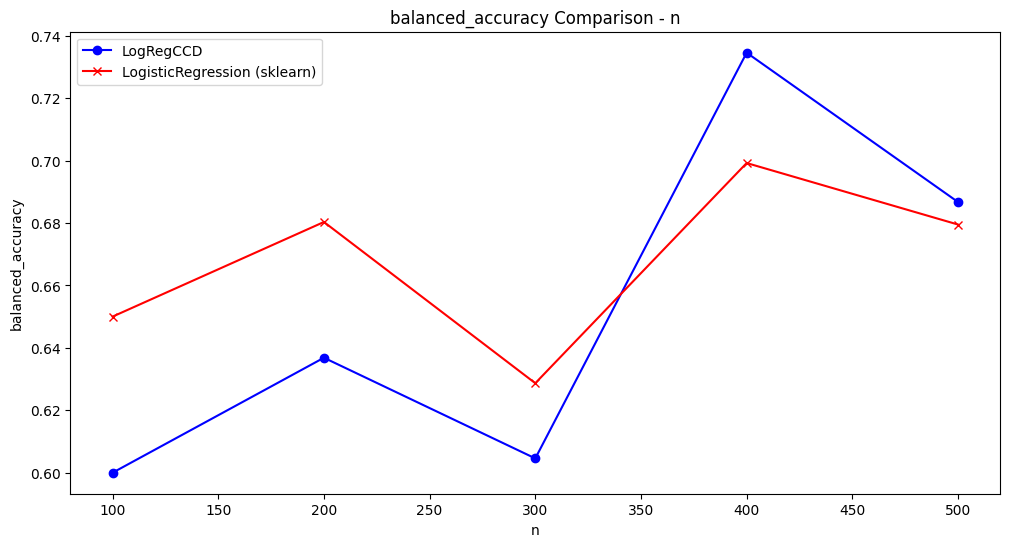

In [11]:
df=results_df[(results_df["p"]==0.5) & (results_df["d"]==10) & (results_df["g"]==0.5)]
plot_comparison('n', 'roc_auc', df) 
plot_comparison('n', 'balanced_accuracy', df) 

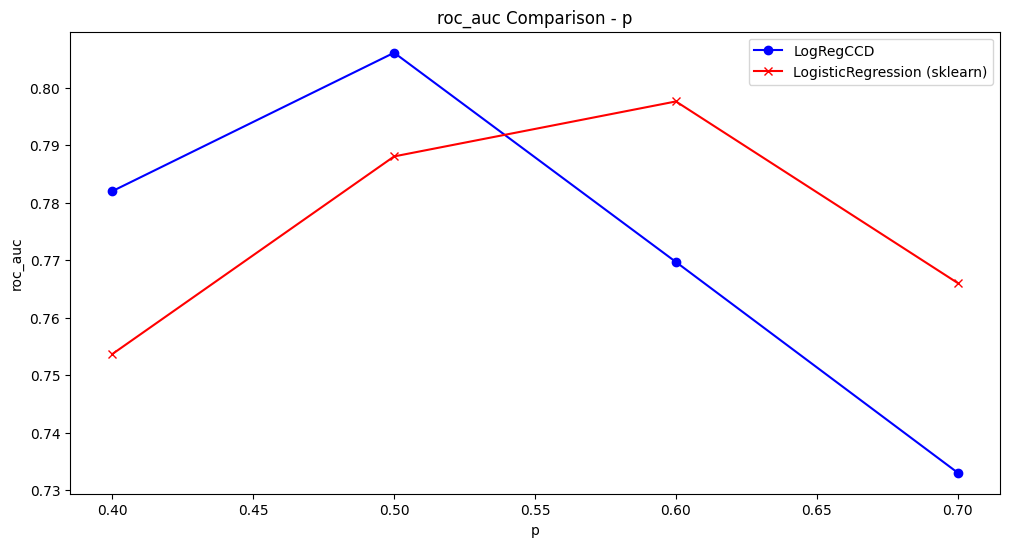

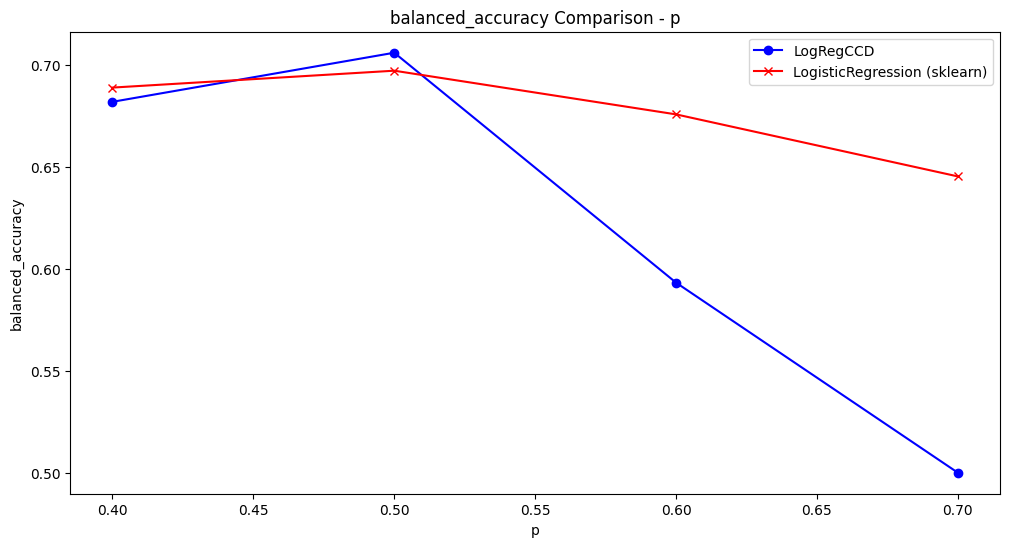

In [12]:
df=results_df[(results_df["n"]==500) & (results_df["d"]==20) & (results_df["g"]==0.1)]
plot_comparison('p', 'roc_auc', df) 
plot_comparison('p', 'balanced_accuracy', df) 

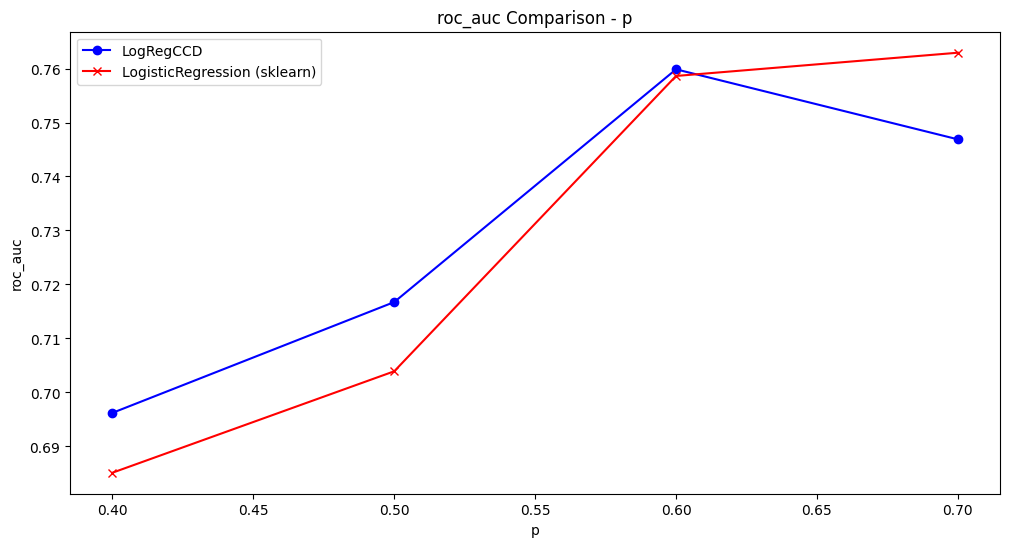

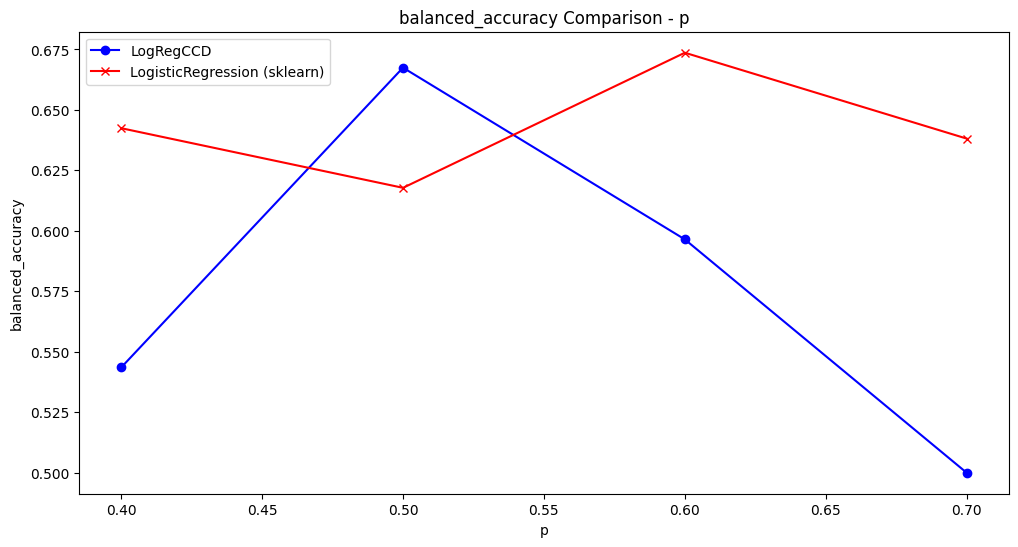

In [13]:
df=results_df[(results_df["n"]==500) & (results_df["d"]==20) & (results_df["g"]==0.5)]
plot_comparison('p', 'roc_auc', df) 
plot_comparison('p', 'balanced_accuracy', df) 

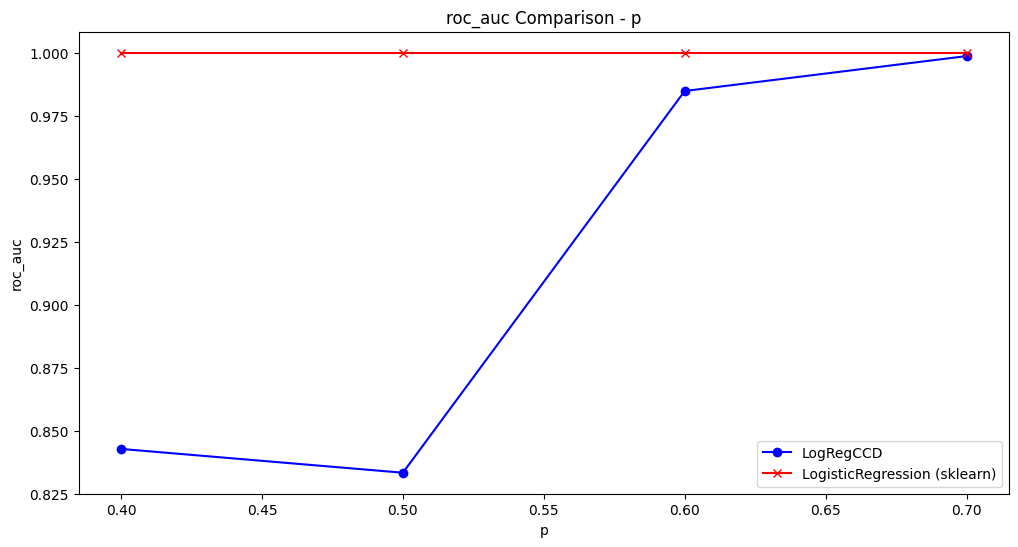

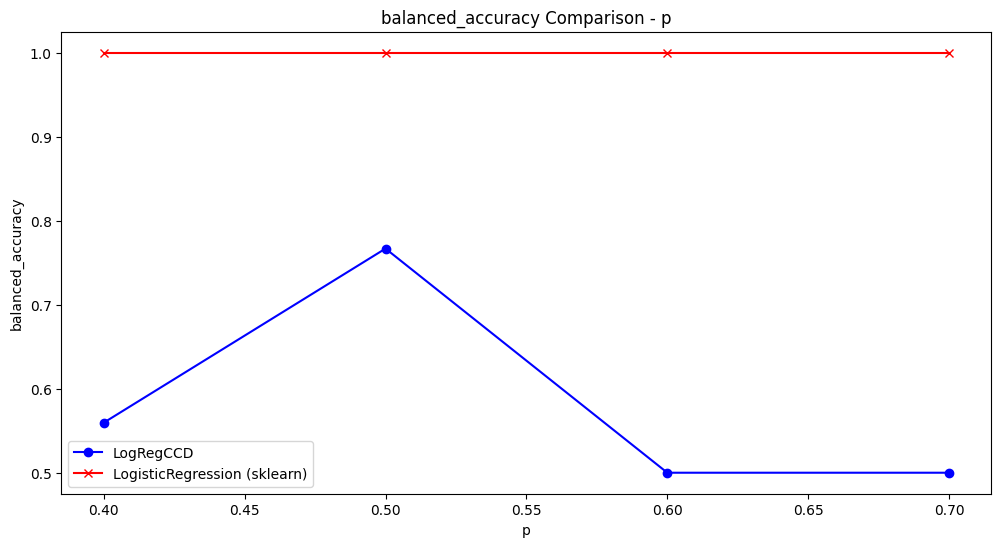

In [14]:
df=results_df[(results_df["n"]==500) & (results_df["d"]==20) & (results_df["g"]==1)]
plot_comparison('p', 'roc_auc', df) 
plot_comparison('p', 'balanced_accuracy', df) 

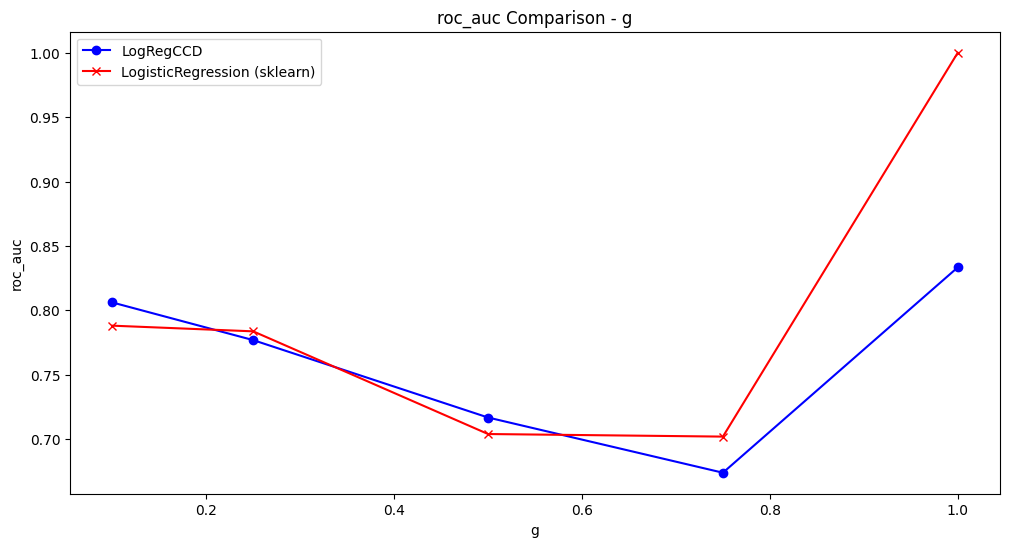

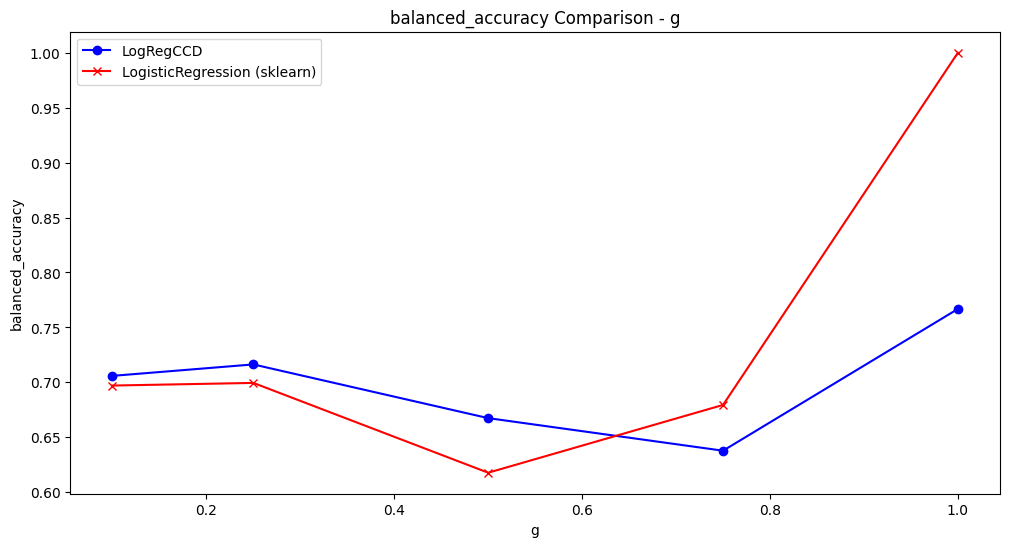

In [15]:
df=results_df[(results_df["n"]==500) & (results_df["p"]==0.5) & (results_df["d"]==20)]
plot_comparison('g', 'roc_auc', df) 
plot_comparison('g', 'balanced_accuracy', df) 

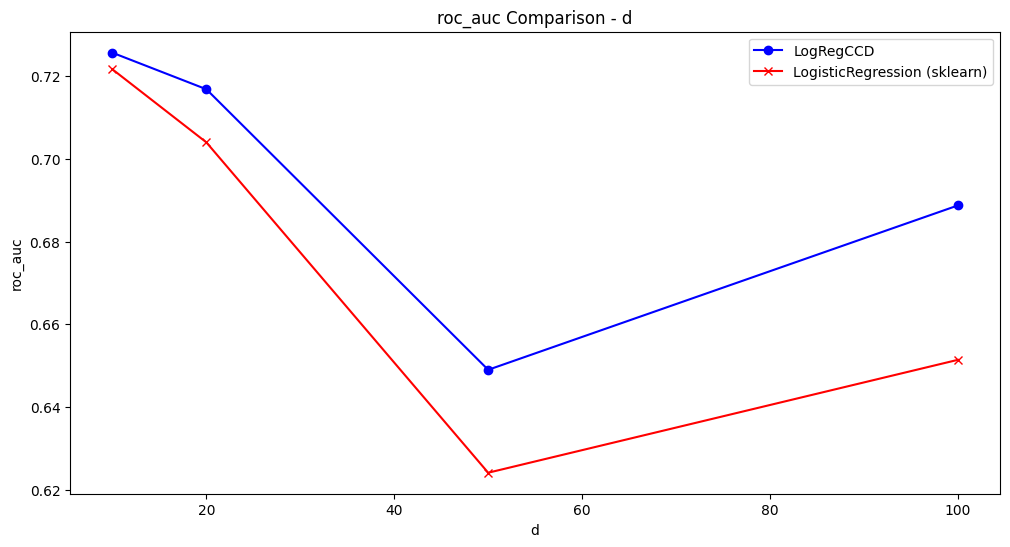

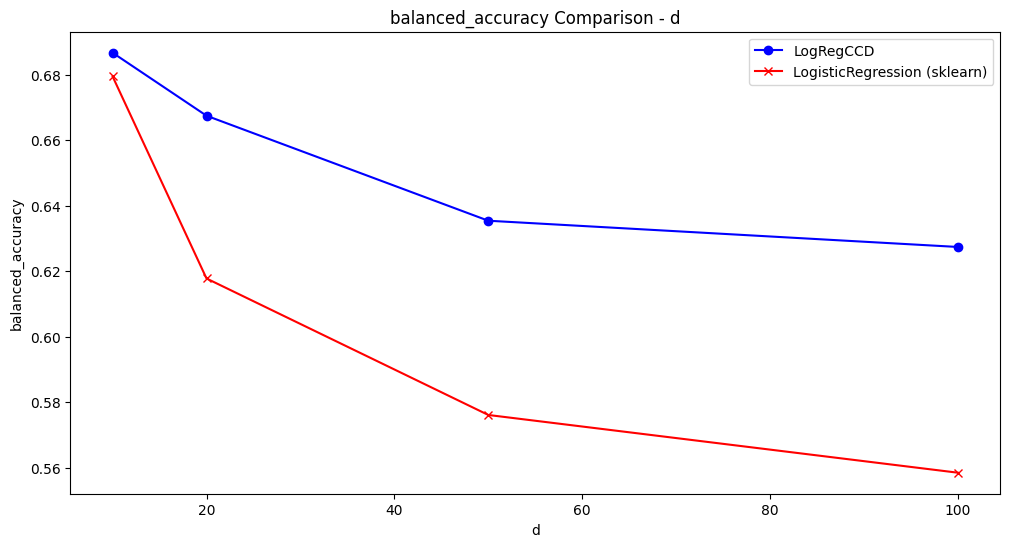

In [16]:
df=results_df[(results_df["n"]==500) & (results_df["p"]==0.5) & (results_df["g"]==0.5)]
plot_comparison('d', 'roc_auc', df) 
plot_comparison('d', 'balanced_accuracy', df) 

## Real datasets experiments

#### Arrythmia

In [36]:
col_names = [f"attr{i}" for i in range(1, 280)]
df_arythmia = pd.read_csv("data/arrhythmia/arrhythmia.data", header=None, names=col_names, na_values="?")
print(df_arythmia.head())
df_arythmia = df_arythmia.reset_index()
df_arythmia.columns = df_arythmia.columns.astype(str)

    attr1  attr2  attr3  attr4  attr5  attr6  attr7  attr8  attr9  attr10  \
75      0    190     80     91    193    371    174    121    -16    13.0   
56      1    165     64     81    174    401    149     39     25    37.0   
54      0    172     95    138    163    386    185    102     96    34.0   
55      0    175     94    100    202    380    179    143     28    11.0   
75      0    190     80     88    181    360    177    103    -16    13.0   

    attr11  attr12  attr13  attr14  attr15  attr16  attr17  attr18  attr19  \
75    64.0    -2.0     NaN    63.0       0      52      44       0       0   
56   -17.0    31.0     NaN    53.0       0      48       0       0       0   
54    70.0    66.0    23.0    75.0       0      40      80       0       0   
55    -5.0    20.0     NaN    71.0       0      72      20       0       0   
75    61.0     3.0     NaN     NaN       0      48      40       0       0   

    attr20  attr21  attr22  attr23  attr24  attr25  attr26  attr27  

In [37]:
assign_target_column(df_arythmia, "attr279", [i for i in range(2,16)])
fill_na(df_arythmia)
delete_corr_columns(df_arythmia)
check_feature_sample_ratio(df_arythmia)

Unique values of label column [ 8  6 10  1  7 14  3 16  2  4  5  9 15]
target
0    267
1    185
Name: count, dtype: int64
attr10 8 null values
attr11 22 null values
attr12 1 null values
attr13 376 null values
attr14 1 null values
deleted features: ['attr160', 'attr163', 'attr170', 'attr184', 'attr192', 'attr193', 'attr194', 'attr203', 'attr207', 'attr211', 'attr214', 'attr217', 'attr224', 'attr234', 'attr243', 'attr254', 'attr263', 'attr273']
Shape after deletion (452, 262)
The number of features is enough: True, number of features: 262


In [38]:
X, y, X_train, X_test, y_train, y_test = split(df_arythmia)

In [ ]:
def evaluate_lr_ccd(X_train, y_train, X_test, y_test, max_iter=50, weights = True):
    model=logisitic_regression()
    best_lambda=model.plot(X=X_train, y=y_train, max_iter=max_iter,weights=weights,measure='balanced accuracy')
    model.plot_coefficients(X=X_train, y=y_train, max_iter=max_iter,weights=weights)
    print("Best lambda",best_lambda)
    model.fit(X_train, y_train, max_iter=max_iter,weights=weights,user_lambda=best_lambda, fit_intercept=True,plots = True)

    
    y_proba = model.predict_proba(X_test)
    #y_pred = model.predict(X_test)

    roc_auc = model.ROC_AUC(y_test, y_proba)
    prc_auc = model.PR_AUC(y_test, y_proba)
    f_score = model.validate(X_test,y_test, 'F-score')
    balanced_accuracy = model.validate(X_test,y_test, 'balanced accuracy')

    print("Performance on test set for custom logistic regression:")
    print("ROC AUC:", roc_auc)
    print("Recall-Precision AUC:", prc_auc)
    print("F-score:", f_score)
    print("Balanced Accuracy:", balanced_accuracy)

    print("Coefficient values obtained (custom model):")
    print("Coefficients:", model.B)
    print("Intercept:", model.B0)

    return model.B

def evaluate_lr_sklearn(X_train, y_train, X_test, y_test):
    model_sklearn = LogisticRegression(penalty=None)
    model_sklearn.fit(X_train, y_train)

    y_proba_sklearn = model_sklearn.predict_proba(X_test)[:, 1]
    y_pred_sklearn = model_sklearn.predict(X_test)

    roc_auc_sklearn = roc_auc_score(y_test, y_proba_sklearn)
    prc_auc_sklearn = average_precision_score(y_test, y_proba_sklearn)
    f_score_sklearn = f1_score(y_test, y_pred_sklearn)
    balanced_accuracy_sklearn = balanced_accuracy_score(y_test, y_pred_sklearn)

    print("Performance on test set for sklearn logistic regression:")
    print("ROC AUC:", roc_auc_sklearn)
    print("Recall-Precision AUC:", prc_auc_sklearn)
    print("F-score:", f_score_sklearn)
    print("Balanced Accuracy:", balanced_accuracy_sklearn)

    print("Coefficient values obtained (sklearn):")
    print("Coefficients:", model_sklearn.coef_)
    print("Intercept:", model_sklearn.intercept_)
    return model_sklearn.coef_

In [10]:
def compare_coefficients(coef_ccd, coef_sk, epsilon=0.01):
    coef1 = np.array(coef_ccd)
    coef2 = np.array(coef_sk)
    norm_coef1 = np.linalg.norm(coef1, axis=0)
    norm_coef2 = np.linalg.norm(coef2, axis=0)
    avg_norm1 = np.mean(norm_coef1)
    avg_norm2 = np.mean(norm_coef2)
    small_coef1 = np.sum(np.abs(coef1) < epsilon)
    small_coef2 = np.sum(np.abs(coef2) < epsilon)

    print(f"Average norm of coefficients from model ccd: {avg_norm1:.4f}")
    print(f"Average norm of coefficients from model sk: {avg_norm2:.4f}")
    print(f"Number of coefficients smaller than {epsilon} in model ccd: {small_coef1}")
    print(f"Number of coefficients smaller than {epsilon} in model sk: {small_coef2}")

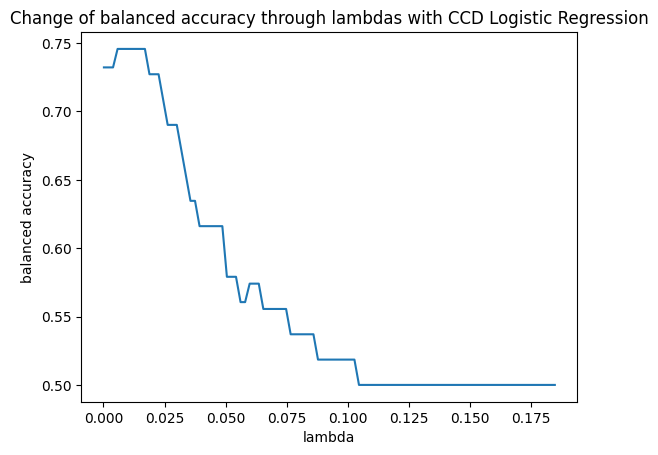

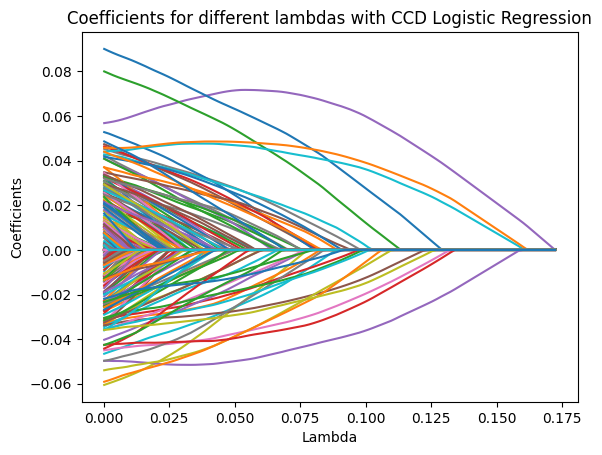

Best lambda 0.01695463085563595


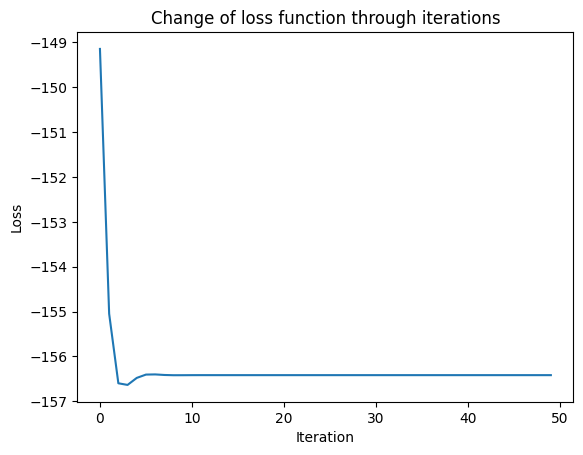

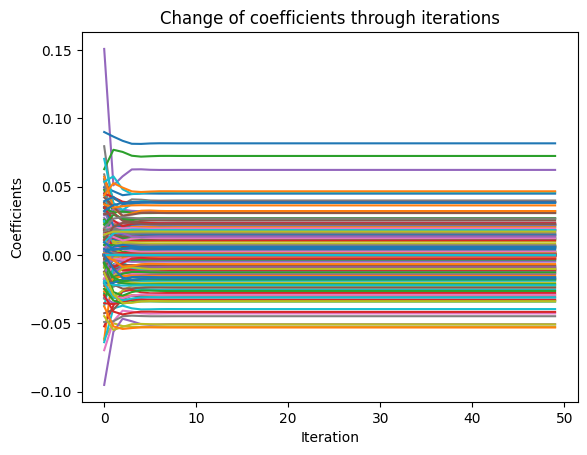

Performance on test set for custom logistic regression:
ROC AUC: 0.8129385964912282
Recall-Precision AUC: 0.7894895658488408
F-score: 0.5777777777777778
Balanced Accuracy: 0.6903508771929825
Coefficient values obtained (custom model):
Coefficients: [-0.         -0.01855364  0.01214688 -0.00960791  0.0622897  -0.00249386
  0.          0.03992218 -0.05247358 -0.00887516 -0.         -0.
 -0.00406564 -0.          0.01408017 -0.0139766   0.          0.03205248
  0.00112571  0.          0.01454885  0.010914   -0.         -0.01136741
  0.          0.          0.          0.          0.00626012  0.0219634
 -0.          0.00164866  0.02184397 -0.          0.          0.01523048
 -0.          0.          0.0015382   0.01510432  0.01504909 -0.00162676
 -0.         -0.01092     0.01788356 -0.         -0.         -0.
 -0.02054502 -0.          0.01823828 -0.          0.02669138  0.
 -0.         -0.00273341  0.          0.          0.01000437  0.
  0.01183331  0.00693534  0.02077904 -0.0111744   0.02

In [40]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test)

In [8]:
#coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test,user_lambda=0.0056, should_plot=False)
#Już zrobione powyżej

In [41]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.731140350877193
Recall-Precision AUC: 0.7570158615453427
F-score: 0.6610169491525424
Balanced Accuracy: 0.7
Coefficient values obtained (sklearn):
Coefficients: [[ 3.76293566e-02 -2.50380621e-02 -1.18117368e-02 -4.02518148e-02
  -1.03065430e-01  9.61948717e-03 -1.64474540e-02  2.90666294e-02
  -5.07693929e-02  2.34220349e-03  1.10284744e-02 -1.34283616e-03
  -1.22200645e-01 -9.63092584e-03  7.53641010e-02 -1.55495854e-01
  -1.53836094e-01  2.62751586e-02  1.78267070e-01  0.00000000e+00
   2.84869015e-01  1.01754076e-02 -7.84656865e-03 -8.93919516e-03
   0.00000000e+00  2.02776186e-04  1.23217771e-04 -1.00051646e-01
   9.97475162e-02  4.64939467e-02 -2.52972716e-01  1.83822109e-02
   6.73064337e-02 -3.72703476e-03 -1.31144881e-02  1.63897019e-02
  -8.55893174e-04  9.57028560e-03  1.72471110e-02  1.93551227e-02
   7.93630122e-02 -6.51674314e-02  3.09840109e-02 -1.66395839e-01
  -5.16026242e-03 -3.22315173e-04 -1.53017718

c:\Users\Kuba\.conda\envs\amlenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.2927
Average norm of coefficients from model sk: 0.0509
Number of coefficients smaller than 0.1 in model ccd: 261
Number of coefficients smaller than 0.1 in model sk: 215


#### Secom

In [53]:
df_data = pd.read_csv("./data/secom/secom.data", sep=' ', header=None, na_values="NaN")  
df_label = pd.read_csv("./data/secom/secom_labels.data",sep=' ', header=None, na_values="NaN")

df_label.columns = ["label", "timestamp"]
df_secom = pd.concat([df_data, df_label["label"]], axis=1)
print("Shape:", df_secom.shape)
df_secom.columns = df_secom.columns.astype(str)

assign_target_column(df_secom, "label", [1])
fill_na(df_secom)
delete_corr_columns(df_secom)
df_secom = add_permuted_columns(df_secom)
delete_corr_columns(df_secom)
check_feature_sample_ratio(df_secom)
#X, y, X_train,X_valid, X_test, y_train, y_valid, y_test = split(df_secom)
X, y, X_train, X_test, y_train, y_test = split(df_secom)

Shape: (1567, 591)
Unique values of label column [-1  1]
target
0    1463
1     104
Name: count, dtype: int64
0 6 null values
1 7 null values
2 14 null values
3 14 null values
4 14 null values
5 14 null values
6 14 null values
7 9 null values
8 2 null values
9 2 null values
10 2 null values
11 2 null values
12 2 null values
13 3 null values
14 3 null values
15 3 null values
16 3 null values
17 3 null values
18 3 null values
19 10 null values
21 2 null values
22 2 null values
23 2 null values
24 2 null values
25 2 null values
26 2 null values
27 2 null values
28 2 null values
29 2 null values
30 2 null values
31 2 null values
32 1 null values
33 1 null values
34 1 null values
35 1 null values
36 1 null values
37 1 null values
38 1 null values
39 1 null values
40 24 null values
41 24 null values
42 1 null values
43 1 null values
44 1 null values
45 1 null values
46 1 null values
47 1 null values
48 1 null values
49 1 null values
50 1 null values
51 1 null values
52 1 null values
53 4 nul

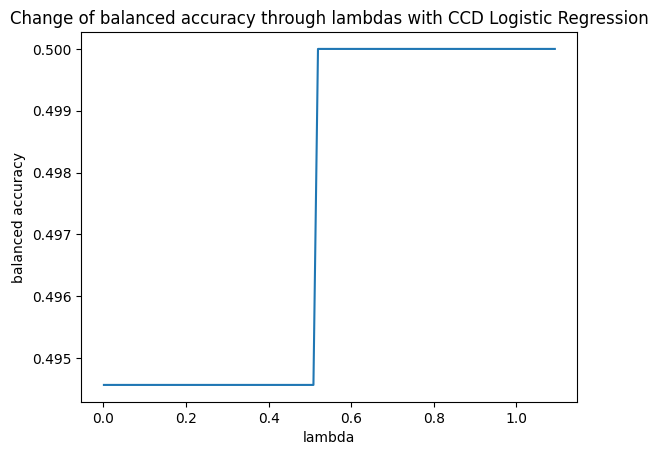

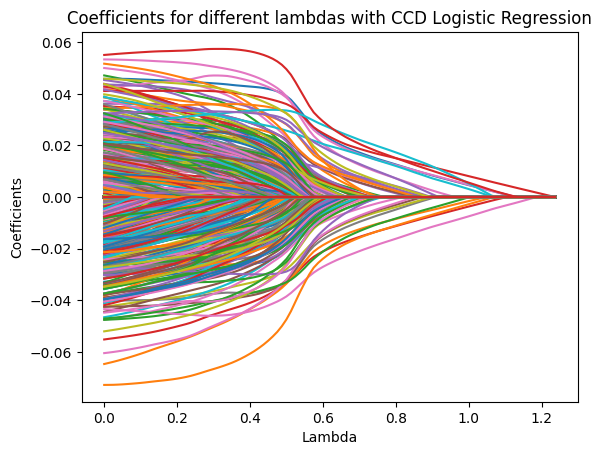

Best lambda 1.093182454404823


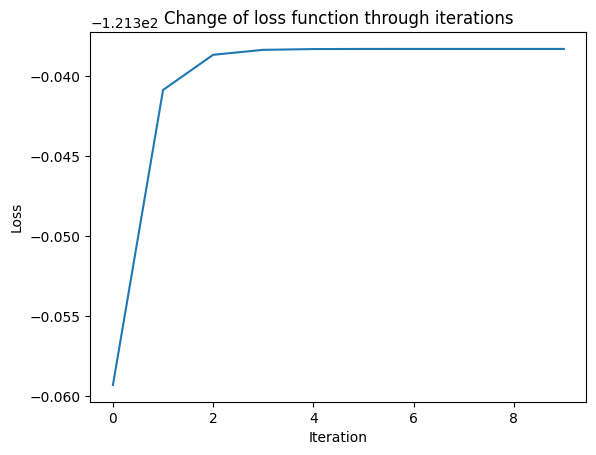

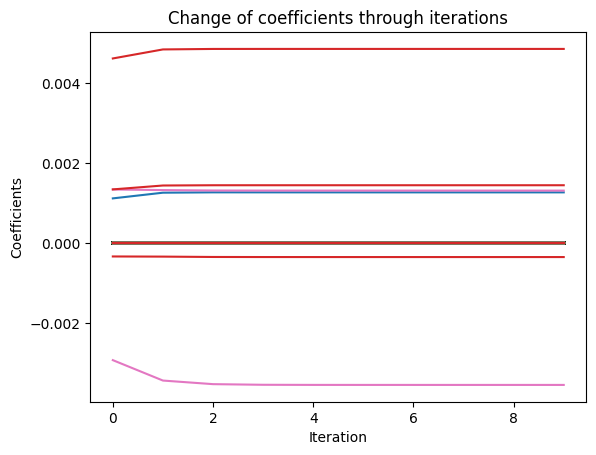

Performance on test set for custom logistic regression:
ROC AUC: 0.5699046920821114
Recall-Precision AUC: 0.13379210870801028
F-score: 0
Balanced Accuracy: 0.5
Coefficient values obtained (custom model):
Coefficients: [-0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.
  0.          0.         -0.         -0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.
  0.          0.         -0.          0.         -0.          0.
  0.00127165  0.         -0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.         -0.
  

In [54]:
coef_ccd=evaluate_lr_ccd(X_train[:500], y_train[:500], X_test, y_test)

In [31]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.8173076923076923
Recall-Precision AUC: 0.6285256281386312
F-score: 0.45454545454545453
Balanced Accuracy: 0.6121794871794872
Coefficient values obtained (sklearn):
Coefficients: [[-7.64836732e-08  6.45541297e-13 -1.69177749e-06 -8.68664974e-06
   4.01306247e-06  2.93989172e-06  1.51195335e-07 -5.41915133e-13
  -1.60728281e-14 -2.01857706e-14  7.45495649e-15  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.07422984e-09  1.92710155e-11
  -2.99554501e-11 -5.28109867e-11 -8.23663912e-09 -5.63974046e-10
  -5.18828156e-08  1.47093618e-06 -3.68613475e-07 -5.48118983e-08
   1.40681946e-08 -4.44517759e-06 -1.14029157e-06 -3.95704183e-08
   1.82398997e-08 -8.74931652e-09 -3.25391302e-09  2.55804580e-07
  -6.52072508e-09 -2.72357362e-10  1.07479973e-09  5.87648116e-11
   2.96499076e-05  3.46762501e-08  8.68059916e-08  1.02884381e-08
   4.21855203e-08  1.30036521e-08  1.51111939e-06 -4.17369237e-07
  -1.81893756e-06  5.7074834

c:\Users\Kuba\.conda\envs\amlenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.1962
Average norm of coefficients from model sk: 0.0000
Number of coefficients smaller than 0.1 in model ccd: 106
Number of coefficients smaller than 0.1 in model sk: 106


#### Braidflow

In [56]:
pd.set_option('display.max_columns', None)

dataset = openml.datasets.get_dataset(45966)

df_braidflow, y, categorical, numeric = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)

df_braidflow["label"] = y
print("Shape:", df_braidflow.shape)
print(df_braidflow.head(1))
df_braidflow["label"].value_counts()

assign_target_column(df_braidflow, "label", ["flow"])
df_braidflow = drop_categorical(df_braidflow)
fill_na(df_braidflow)
delete_corr_columns(df_braidflow)
check_feature_sample_ratio(df_braidflow)
X, y, X_train, X_test, y_train, y_test = split(df_braidflow)

Shape: (72, 124)
   UID  task_id  action_absorption  action_accord  action_fluidity  care  \
0    1        5                  3              7                6     3   

   challenge_match  clear_mindedness  control  demand  \
0                4                 5        6       4   

   factor_absorption_by_activity  factor_fluency_of_performance  \
0                            3.5                       6.333333   

   factor_perceived_fit_of_skill_and_task_demands  \
0                                             5.0   

   factor_subjective_value_of_activity  focus  forward_thinking  fss_score  \
0                             2.333333      7                 7        5.2   

   loss_of_time_perception  lost_in_thought  perceived_difficulty  relevance  \
0                        6                1                     4          3   

   self_evaluation  worry task_braid  task_braid_revolutions  \
0                7      1     VBRAID                       6   

   task_braid_strands  bra

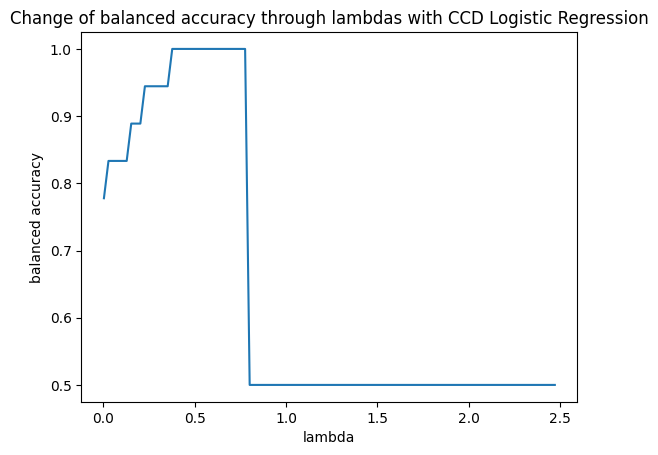

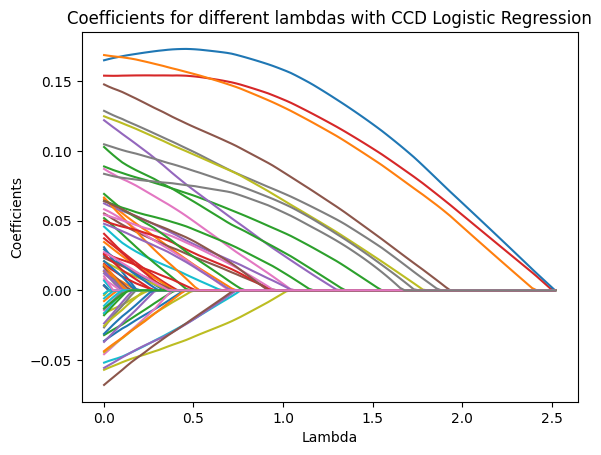

Best lambda 0.7753843766846567


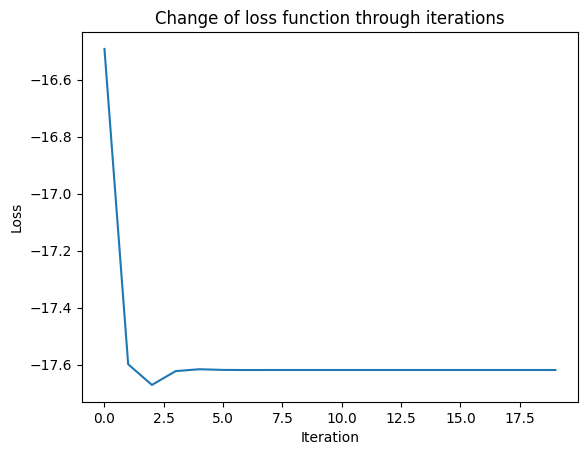

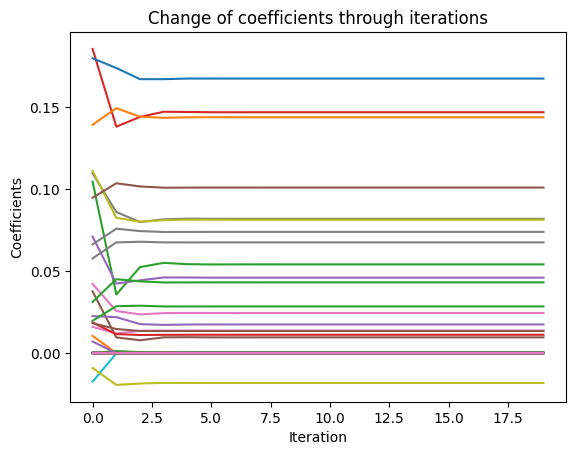

Performance on test set for custom logistic regression:
ROC AUC: 0.9764705882352941
Recall-Precision AUC: 0.7183333333333334
F-score: 0.33333333333333337
Balanced Accuracy: 0.6
Coefficient values obtained (custom model):
Coefficients: [-0.          0.          0.05414068  0.14704237  0.04603676  0.00957591
  0.02444469  0.08196622  0.08137355 -0.          0.16760002  0.14396619
 -0.          0.          0.01743424  0.10105412  0.          0.07397979
 -0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.
  0.          0.          0.02844787  0.         -0.         -0.
  0.01365536  0.          0.         -0.         -0.          0.
  0.          0.01115831  0.          0.          0.         -0.
 -0.01827326 -0.          0.          0.          0.04316913  0.
 -0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.0003541   0.          0.         -0.
  0.         -0.         -

In [57]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test)

In [58]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.7058823529411764
Recall-Precision AUC: 0.5082051282051283
F-score: 0.0
Balanced Accuracy: 0.5
Coefficient values obtained (sklearn):
Coefficients: [[-3.17810250e-07  6.96383690e-08  2.32483684e-07  3.52260242e-07
   2.47917736e-07  2.17471672e-07  1.79107876e-07  2.88636604e-07
   2.97067949e-07 -1.34969242e-07  2.23576337e-07  2.88780256e-07
  -4.71803195e-08  9.50096522e-08  2.46753962e-07  3.00045046e-07
   1.53517287e-07  3.29196499e-07 -1.47850846e-07  1.43833737e-07
   1.41279130e-07 -7.62764518e-08 -4.03831536e-08 -1.14498022e-06
   1.73612832e-10  8.89122674e-11  7.07661985e-11  9.22036221e-12
   5.49459445e-12 -2.56747031e-10 -3.81022803e-12  3.40825663e-10
   7.50098569e-09  4.54029315e-09 -3.79673274e-10 -6.36318107e-10
   1.65143141e-07  8.02840961e-07  1.97697058e-10 -1.00419029e-10
  -6.93212257e-10  7.34998580e-10  6.52449723e-10  2.63034454e-10
   1.32545135e-10  1.11368082e-07  4.97424991e-08 -1.278661

In [59]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.3370
Average norm of coefficients from model sk: 0.0000
Number of coefficients smaller than 0.1 in model ccd: 74
Number of coefficients smaller than 0.1 in model sk: 78


#### LSVT

In [25]:
dataset = openml.datasets.get_dataset(1484)
df_lsvt, y, categorical, numeric = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)

df_lsvt["label"] = y
print("Shape:", df_lsvt.shape)
print(df_lsvt.head(1))
df_lsvt["label"].value_counts()

assign_target_column(df_lsvt, "label", ['1'])
fill_na(df_lsvt)
delete_corr_columns(df_lsvt)
check_feature_sample_ratio(df_lsvt)
X, y, X_train, X_test, y_train, y_test = split(df_lsvt)

Shape: (126, 311)
         V1        V2       V3        V4        V5        V6        V7  \
0  0.088112  0.041697  0.00048 -0.000004  0.000422  2.458381  0.000001   

          V8          V9       V10       V11       V12       V13       V14  \
0  47.021079  1366.43039 -7.103323 -2.687924 -0.035674  2.849068  0.042287   

        V15       V16      V17       V18       V19      V20       V21  \
0  9.116401  0.000002  0.04192  0.000482  0.000004  0.00044  0.000055   

        V22  V23       V24  V25  V26  V27  V28       V29       V30       V31  \
0  0.000001  0.0  0.000001  0.0    0    0    0  0.042287  0.000204  0.069838   

         V32      V33       V34      V35      V36       V37      V38  \
0  11.566415  0.07716 -0.000064  0.08188  0.09207 -0.000057  0.08188   

        V39       V40      V41       V42       V43       V44       V45  \
0  0.100744  0.000057  0.08188  0.059512  1.012151  0.021821  0.076036   

        V46      V47       V48       V49       V50       V51        V52  \

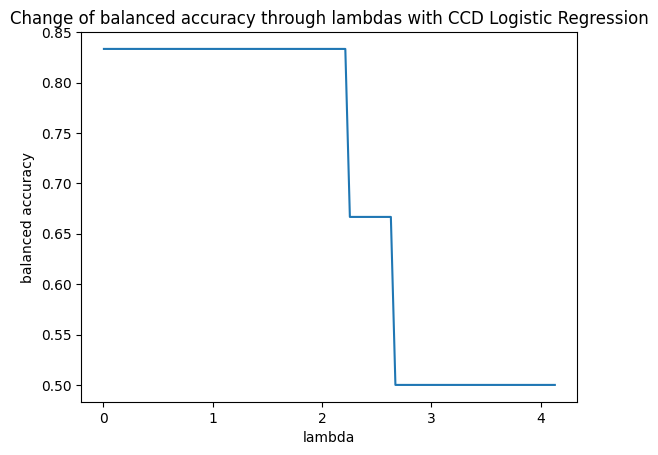

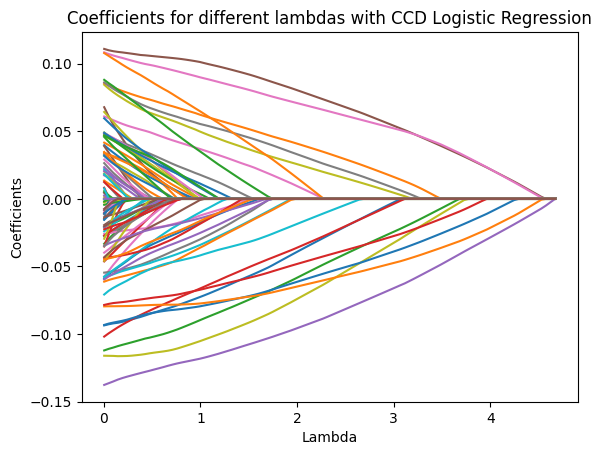

Best lambda 2.212929542901602


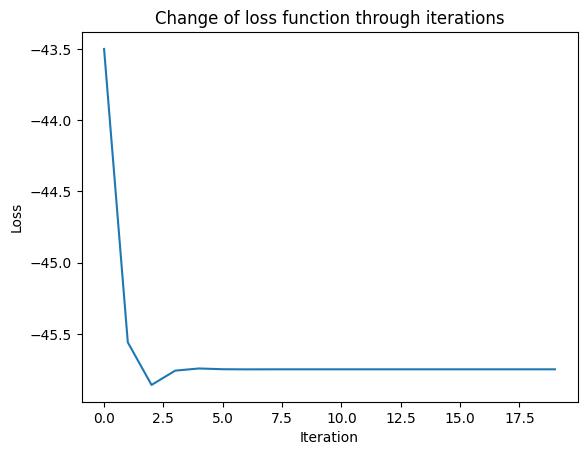

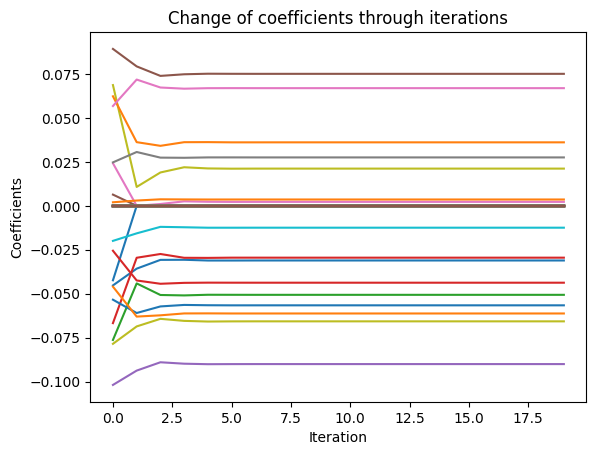

Performance on test set for custom logistic regression:
ROC AUC: 0.9647435897435896
Recall-Precision AUC: 0.8430622754152165
F-score: 0.2857142857142857
Balanced Accuracy: 0.5833333333333334
Coefficient values obtained (custom model):
Coefficients: [-0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
 -0.06572231 -0.         -0.03110407  0.         -0.05063936 -0.
  0.         -0.         -0.         -0.          0.0211588  -0.
 -0.          0.         -0.         -0.          0.         -0.
  0.0022382   0.          0.         -0.          0.          0.0361011
  0.         -0.02950137 -0.09003053  0.0750638   0.06691807  0.02752012
  0.         -0.          0.          0.00358684  0.         -0.
  0.         -0.          0.          0.          0.         -0.
  0.          0.         -0.         -0.         -0.          0.
 -0.          0.     

In [26]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test)

In [28]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.8173076923076923
Recall-Precision AUC: 0.6285256281386312
F-score: 0.45454545454545453
Balanced Accuracy: 0.6121794871794872
Coefficient values obtained (sklearn):
Coefficients: [[-7.64836732e-08  6.45541297e-13 -1.69177749e-06 -8.68664974e-06
   4.01306247e-06  2.93989172e-06  1.51195335e-07 -5.41915133e-13
  -1.60728281e-14 -2.01857706e-14  7.45495649e-15  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.07422984e-09  1.92710155e-11
  -2.99554501e-11 -5.28109867e-11 -8.23663912e-09 -5.63974046e-10
  -5.18828156e-08  1.47093618e-06 -3.68613475e-07 -5.48118983e-08
   1.40681946e-08 -4.44517759e-06 -1.14029157e-06 -3.95704183e-08
   1.82398997e-08 -8.74931652e-09 -3.25391302e-09  2.55804580e-07
  -6.52072508e-09 -2.72357362e-10  1.07479973e-09  5.87648116e-11
   2.96499076e-05  3.46762501e-08  8.68059916e-08  1.02884381e-08
   4.21855203e-08  1.30036521e-08  1.51111939e-06 -4.17369237e-07
  -1.81893756e-06  5.7074834

c:\Users\Kuba\.conda\envs\amlenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.1962
Average norm of coefficients from model sk: 0.0000
Number of coefficients smaller than 0.1 in model ccd: 106
Number of coefficients smaller than 0.1 in model sk: 106
